# Use example of XAI on various datasets using models trained beforehand.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
from src.core.data import load_big_cats, load_garbage, load_stl10, load_pediatric_pneumonia
from src.core.data._config import BIG_CATS_IMAGE_SIZE, GARBAGE_IMAGE_SIZE, STL10_IMAGE_SIZE, PEDIATRIC_PNEUMONIA_IMAGE_SIZE
from src.core.models import AlexNet, ResNet18, ResNet34
from src.core.pipelines import Classifier_Pipeline, Pipeline_Config, load_model
from src.core.analysis.xai import (
    Grad_CAM, Integrated_Gradients,
    Gradient_Ascent,
    ROAD, Average_Sensitivity
)
from src.config import BIG_CATS_PIPELINE_CONFIG, STL10_PIPELINE_CONFIG, PEDIATRIC_PNEUMONIA_PIPELINE_CONFIG

## Definition of XAI pipeline
Since we are going to repeat it many times, we may as well predefine it

In [3]:
# Auxiliary function
def create_overlay(image: torch.Tensor, saliency_map: torch.Tensor, alpha: float = 0.5) -> plt.Figure:
    """
    Create an overlay of saliency map on original image
    
    Args:
        image: Original image tensor of shape [1, C, H, W] or [C, H, W]
        saliency_map: Saliency map tensor of shape [H, W]
        alpha: Transparency of overlay
        
    Returns:
        Matplotlib figure object ready to be displayed
    """

    if image.dim() == 4:
        image = image.squeeze(0)
    
    img_np = image.cpu().detach().permute(1, 2, 0).numpy()
    
    saliency_np = saliency_map.cpu().detach().numpy()
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_np)
    ax.imshow(saliency_np, cmap='jet', alpha=alpha)
    ax.axis('off')
    
    return fig

In [4]:
def local_xai_pipeline(
    image: torch.Tensor,
    target_class: int,
    saliency_explainer,
    road_evaluator,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> None:
    """
    """

    saliency_map = saliency_explainer.explain(img, target_class)
    road_results = road_evaluator.evaluate(
        img, 
        saliency_map, 
        target_class,
        percentiles=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        metrics=['deletion', 'insertion'],
        verbose=False
    )
    as_eval = Average_Sensitivity(saliency_explainer.explain, device=device)
    as_results = as_eval.evaluate_across_noise_levels(
        image,
        target_class,
        n_samples=30,
        verbose=False
    )

    overlay = create_overlay(image, saliency_map)
    overlay.show()
    road_evaluator.plot_curves(road_results, show=True)
    road_evaluator.visualize_removal_steps(image, saliency_map, percentiles=[0, 10, 30, 50, 70, 90], show=True)
    as_eval.plot_noise_level_analysis(as_results, show=True)
    
    print(f"""
        Summary
        - Faithfulness: {road_results['deletion']['auc']}
        - Robustness: {np.mean(as_results["sensitivities"])}
        """
    )

In [5]:
def global_xai_pipeline(
    model,
    image_size,
    num_channels,
    target_class: int,
    class_name: str,
    iterations = 300,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> None:
    """
    """

    ga = Gradient_Ascent(model, target_class, image_size, channels=num_channels)

    image = ga.generate(
        iterations = 300,
        lr = 0.1,
        l2_weight = 0.001,
        tv_weight = 0.01,
        blur_freq = 10,
        blur_sigma = 0.5,
        init_type = 'random',
        jitter = 0,
        verbose = True
    )

    ga.visualize(
        image,
        title=f"Gradient Ascent generated image for class {class_name}",
        show=True
    )


## LST10

### Initial evaluation of the model

In [37]:
!python -m src.evaluate --data stl10 --model-name pretrained/STL10_ResNet34_base_model

Loading data for stl10...DONE
Using model: pretrained/STL10_ResNet34_base_model
Using device: cuda
Test accuracy: 0.789875
Evaluation registered with MLflow


### Load data

In [7]:
_, _, data = load_stl10()

### Load model and pipeline

In [8]:
# Model
jit_model, model_name = load_model("pretrained/STL10_ResNet34_base_model")
model = ResNet34(in_channels=3, num_classes=10, small_inputs=True)
model.load_state_dict(jit_model.state_dict())

# Pipeline for predictions
pipeline = Classifier_Pipeline(model, config=Pipeline_Config(**STL10_PIPELINE_CONFIG))

### Local XAI

#### Prepare methods

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc = Grad_CAM(model, target_layer_name="processing_block.15.conv_branch.3")
ig = Integrated_Gradients(model)
road = ROAD(model, device=device)

#### Select instance

In [13]:
imgs, labels = next(iter(data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.78039217].


torch.Size([1, 3, 96, 96]) 0


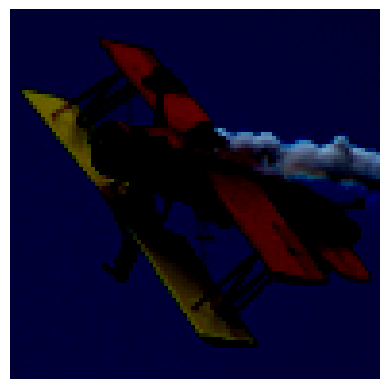

In [31]:
i = 10
img = imgs[i:i+1].to(device)
label = labels[i].item()

print(img.shape, label)

img_display = img.squeeze().permute(1, 2, 0) if hasattr(img, 'permute') else img.squeeze().transpose(1, 2, 0)
if hasattr(img_display, 'detach'):
    img_display = img_display.detach().cpu().numpy()

plt.imshow(img_display)
plt.axis('off')
plt.show()

In [32]:
target_class = pipeline.predict(img).item()
print("Target class:", label, "Predicted class:", target_class)

Target class: 0 Predicted class: 0


#### Grad-CAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.78039217].
C:\Users\pablo\AppData\Local\Temp\ipykernel_31152\2995559697.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  overlay.show()


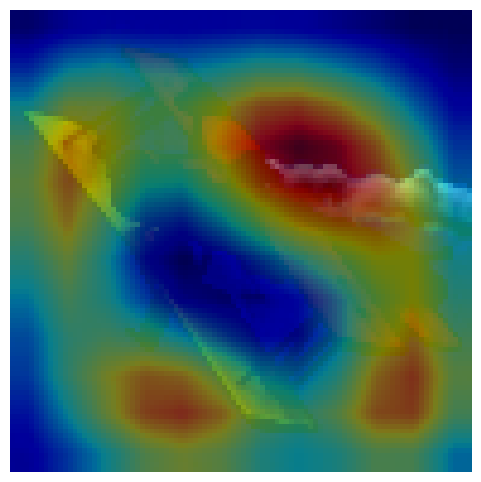

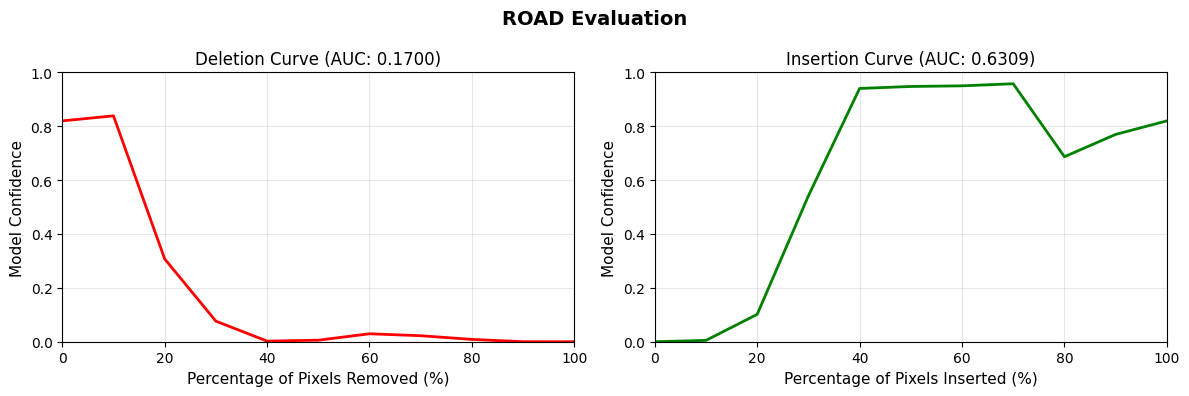

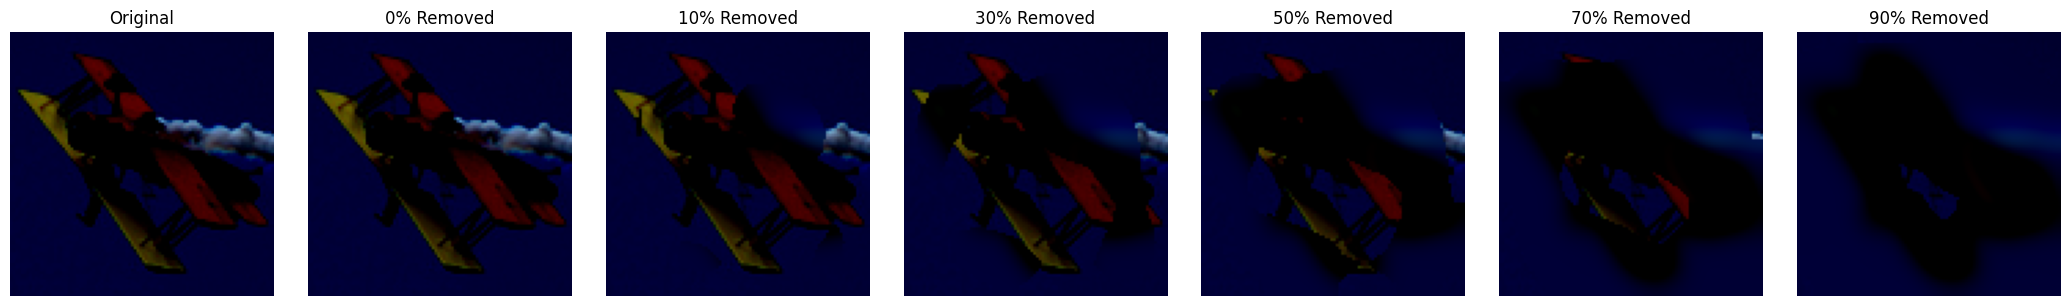

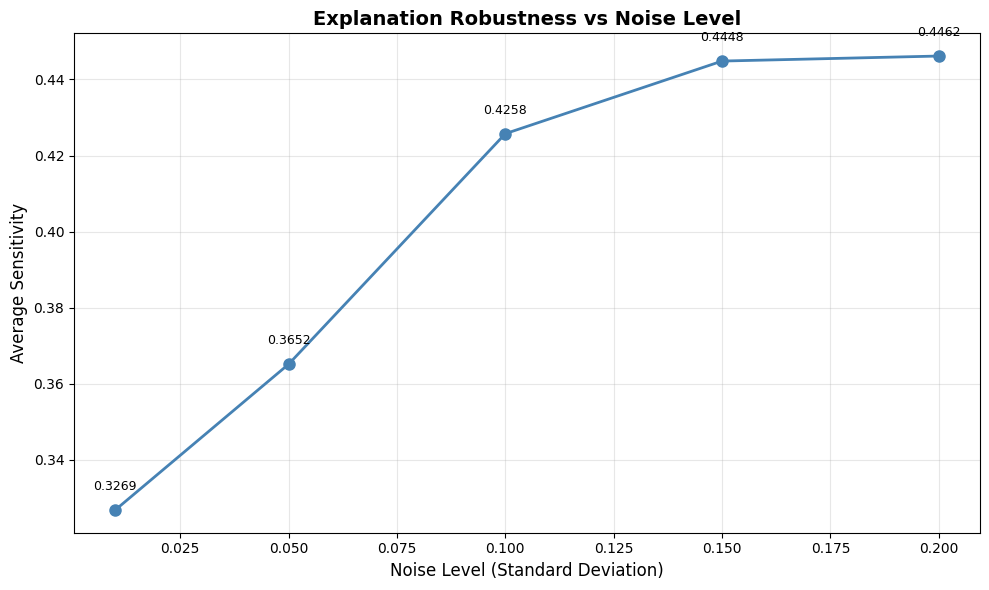


        Summary
        - Faithfulness: 0.1700489616394043
        - Robustness: 0.40175841450691224
        


In [33]:
local_xai_pipeline(img, target_class, gc, road)

#### Integrated Gradients

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.78039217].
C:\Users\pablo\AppData\Local\Temp\ipykernel_31152\2995559697.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  overlay.show()


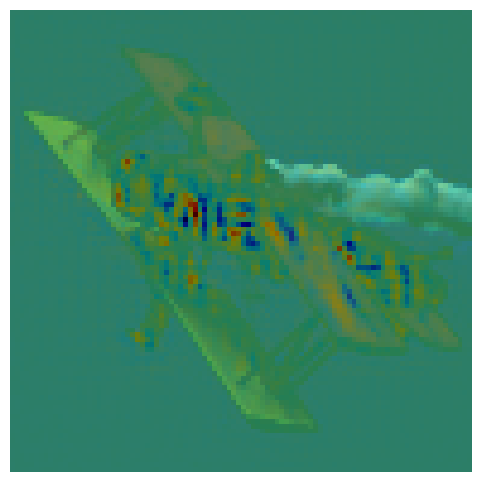

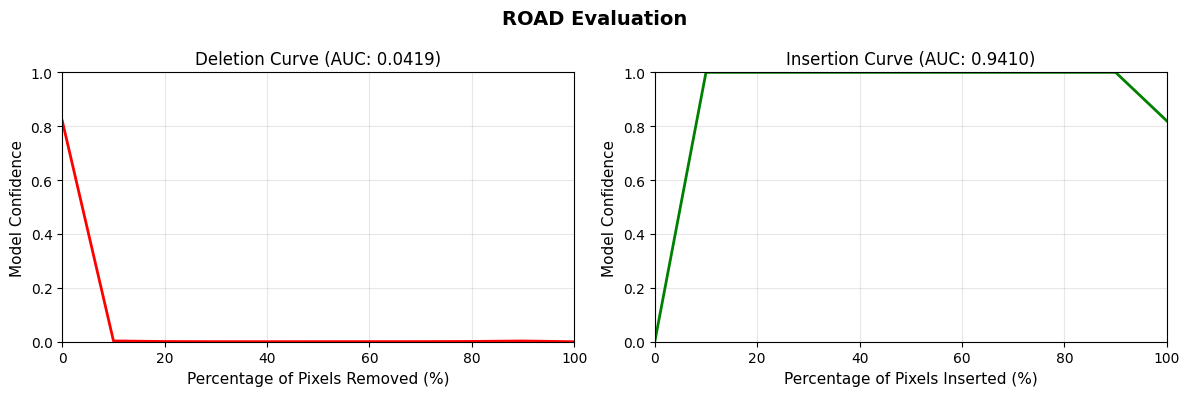

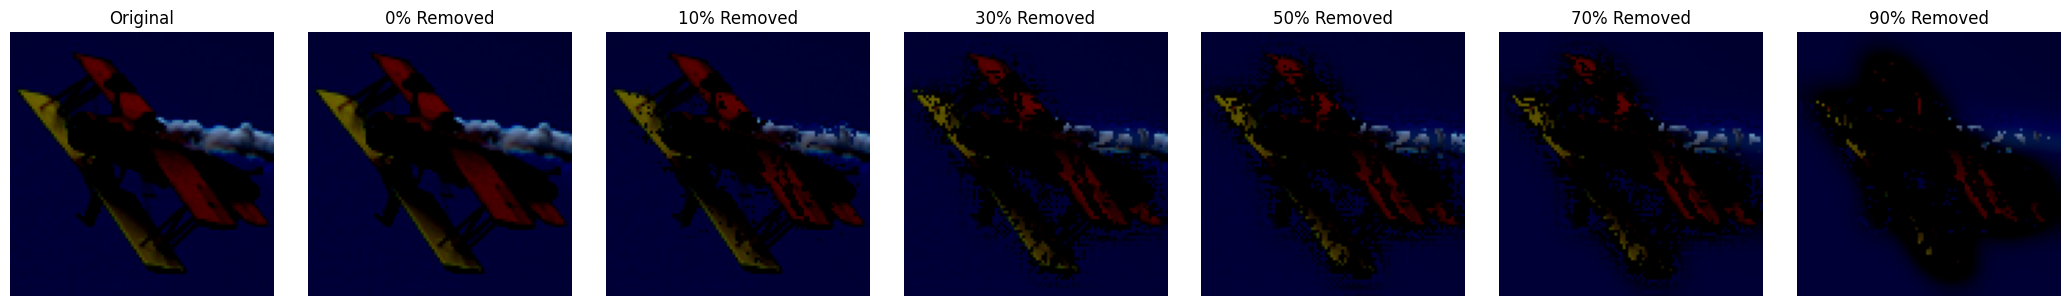

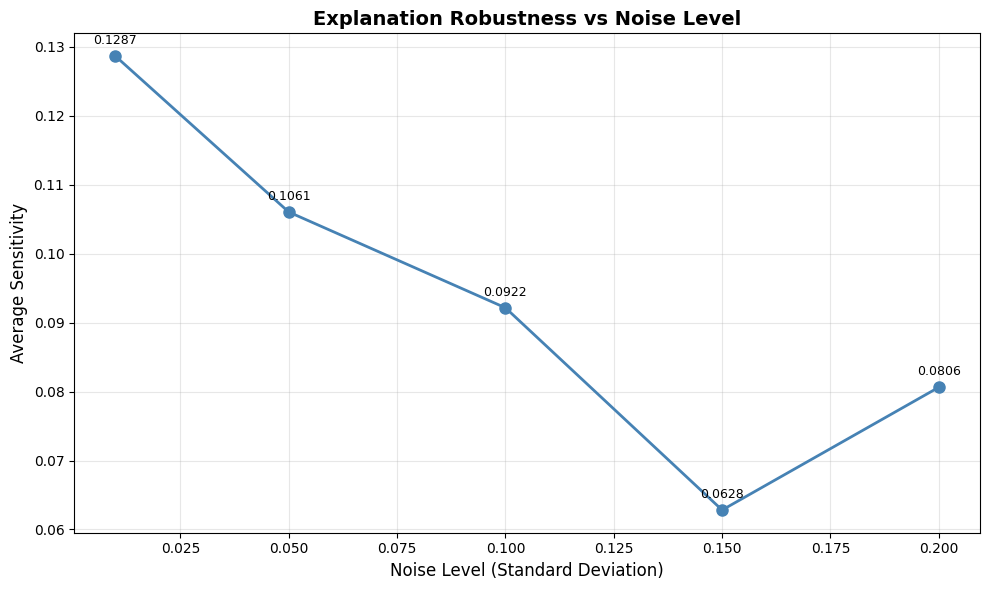


        Summary
        - Faithfulness: 0.04192027568817139
        - Robustness: 0.09406594038009644
        


In [34]:
local_xai_pipeline(img, target_class, ig, road)

### Global XAI

In [35]:
data.dataset.classes

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

Iteration 50/300, Class score: 46.1439
Iteration 100/300, Class score: 46.1869
Iteration 150/300, Class score: 47.0720
Iteration 200/300, Class score: 47.9599
Iteration 250/300, Class score: 45.7258
Iteration 300/300, Class score: 47.3895


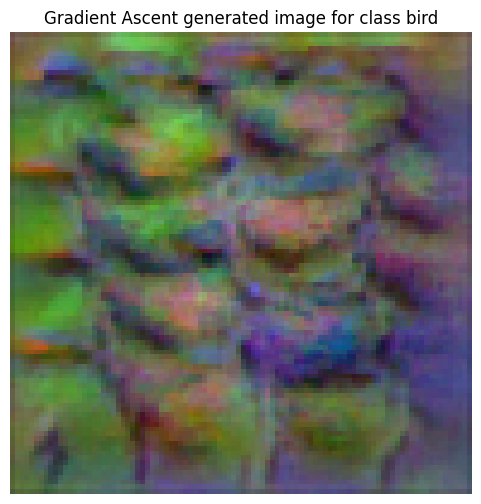

In [36]:
ga_class = 1
global_xai_pipeline(
    model,
    STL10_IMAGE_SIZE,
    3,
    ga_class,
    data.dataset.classes[ga_class],
    device
)

## Big Cats

In [38]:
!python -m src.evaluate --data big_cats --model-name pretrained/Big_Cats_ResNet34_base_model

_, _, data = load_big_cats()

jit_model, model_name = load_model("pretrained/Big_Cats_ResNet34_base_model")
model_resnet = ResNet34(in_channels=3, num_classes=10, small_inputs=False)
model_resnet.load_state_dict(jit_model.state_dict())
pipeline_resnet = Classifier_Pipeline(model_resnet, config=Pipeline_Config(**BIG_CATS_PIPELINE_CONFIG))

Loading data for big_cats...DONE
Using model: pretrained/Big_Cats_ResNet34_base_model
Using device: cuda
Test accuracy: 0.9799999594688416
Evaluation registered with MLflow


In [39]:
!python -m src.evaluate --data big_cats --model-name pretrained/Big_Cats_Alexnet_base_model

jit_model, model_name = load_model("pretrained/Big_Cats_Alexnet_base_model")
model_alexnet = AlexNet(input_channels=3, num_classes=10)
model_alexnet.load_state_dict(jit_model.state_dict())
pipeline_alexnet = Classifier_Pipeline(model_alexnet, config=Pipeline_Config(**BIG_CATS_PIPELINE_CONFIG))

Loading data for big_cats...DONE
Using model: pretrained/Big_Cats_Alexnet_base_model
Using device: cuda
Test accuracy: 0.7199999690055847
Evaluation registered with MLflow


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc_resnet = Grad_CAM(model_resnet, target_layer_name="processing_block.15.conv_branch.3")
ig_resnet = Integrated_Gradients(model_resnet)
road_resnet = ROAD(model_resnet, device=device)
gc_alexnet = Grad_CAM(model_alexnet, target_layer_name="features.10")
ig_alexnet = Integrated_Gradients(model_alexnet)
road_alexnet = ROAD(model_alexnet, device=device)

### Local XAI

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].


torch.Size([1, 3, 200, 200]) 4


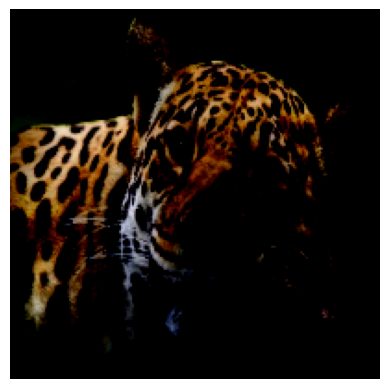

In [40]:
imgs, labels = next(iter(data))

i = 0
img = imgs[i:i+1].to(device)
label = labels[i].item()

print(img.shape, label)

img_display = img.squeeze().permute(1, 2, 0) if hasattr(img, 'permute') else img.squeeze().transpose(1, 2, 0)
if hasattr(img_display, 'detach'):
    img_display = img_display.detach().cpu().numpy()

plt.imshow(img_display)
plt.axis('off')
plt.show()

In [41]:
target_class_resnet = pipeline_resnet.predict(img).item()
target_class_alexnet = pipeline_alexnet.predict(img).item()
classes = data.dataset.classes
print("ResNet |", "Target class:", classes[label], "Predicted class:", classes[target_class_resnet])
print("AlexNet |", "Target class:", classes[label], "Predicted class:", classes[target_class_alexnet])

ResNet | Target class: JAGUAR Predicted class: JAGUAR
AlexNet | Target class: JAGUAR Predicted class: JAGUAR


#### Grad-CAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
C:\Users\pablo\AppData\Local\Temp\ipykernel_31152\2995559697.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  overlay.show()


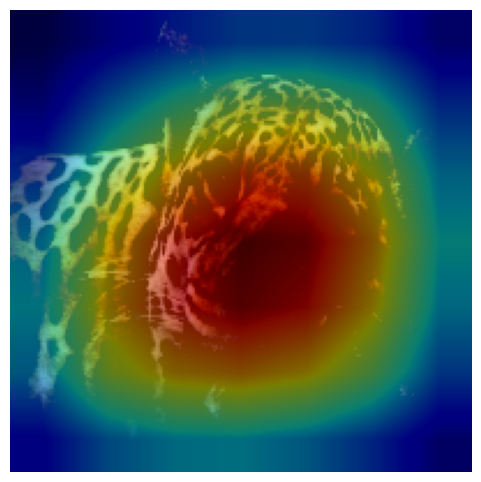

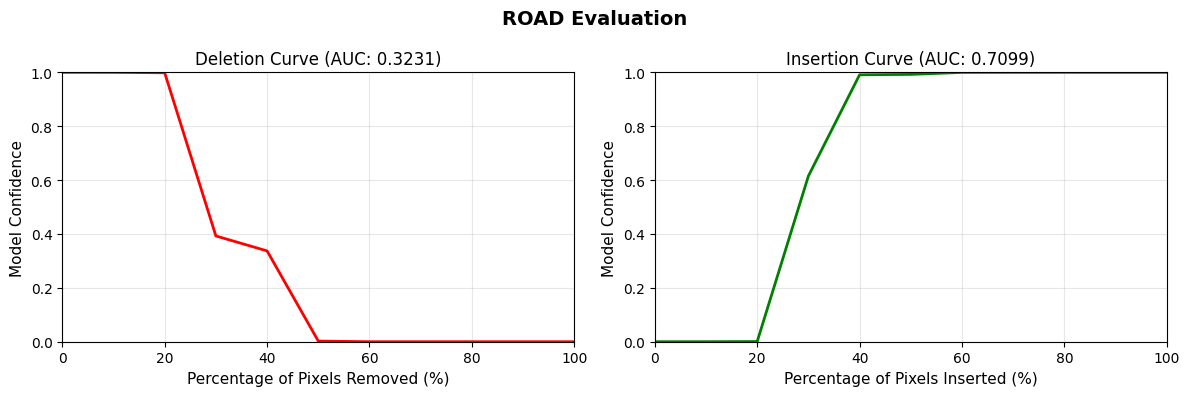

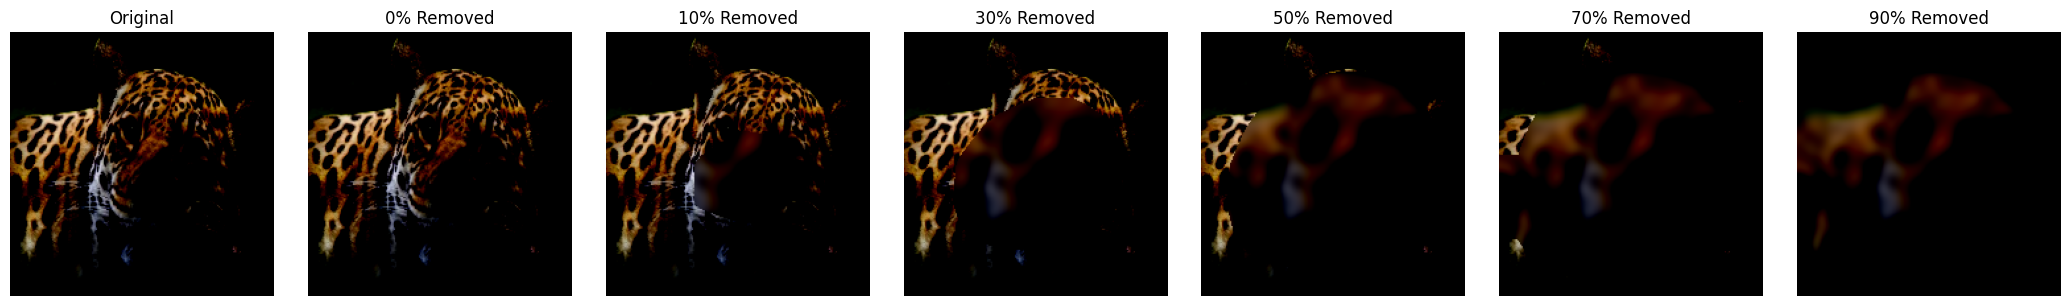

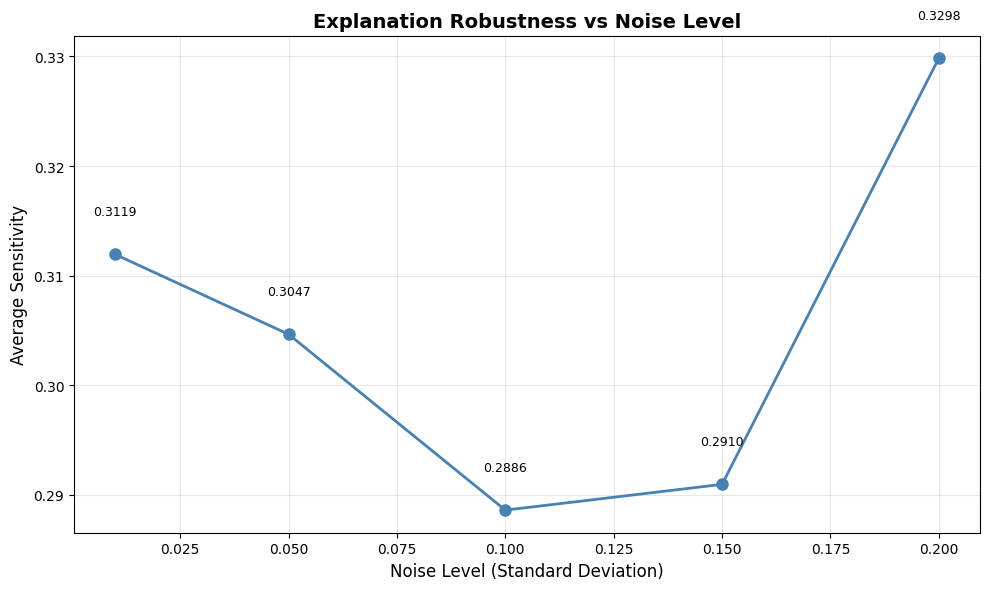


        Summary
        - Faithfulness: 0.32305030822753905
        - Robustness: 0.3052029609680176
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].


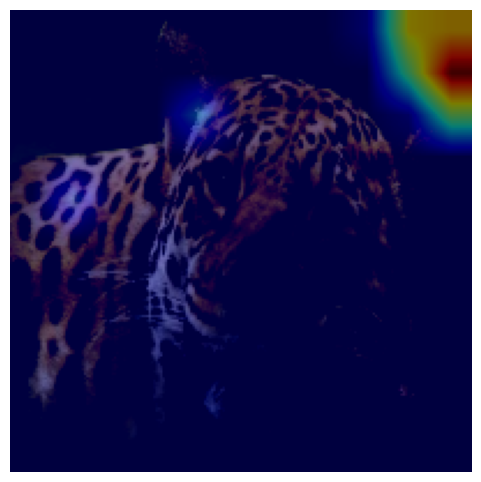

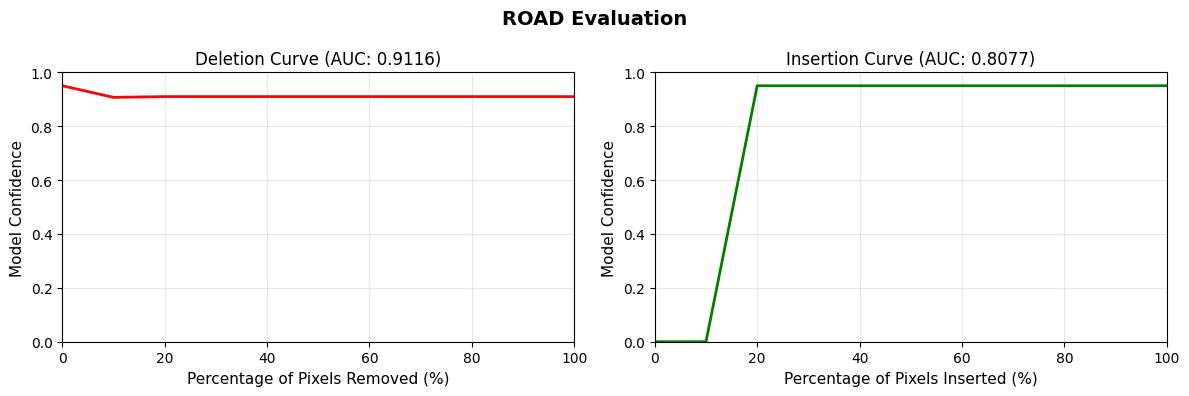

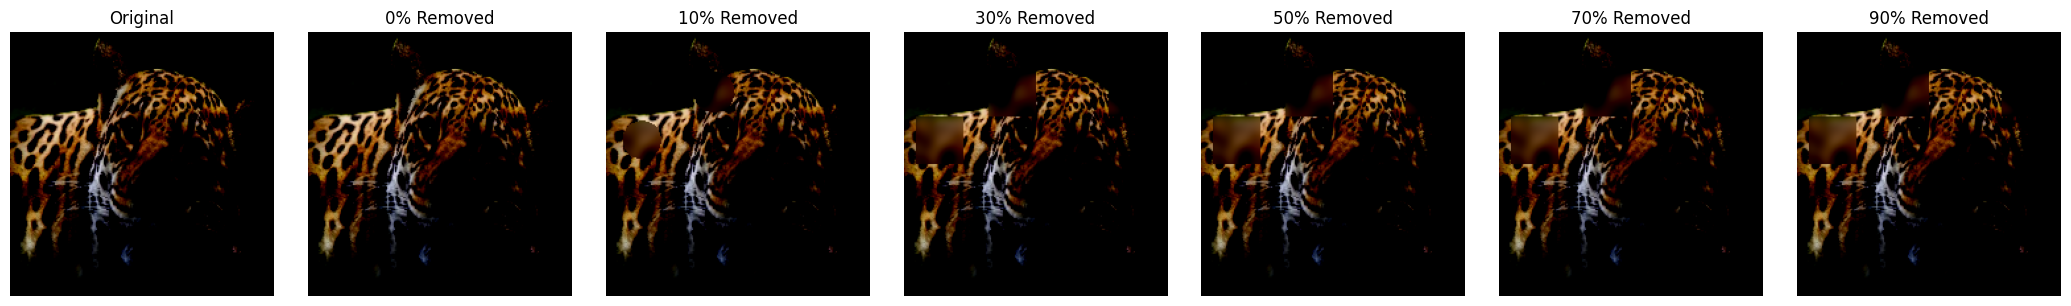

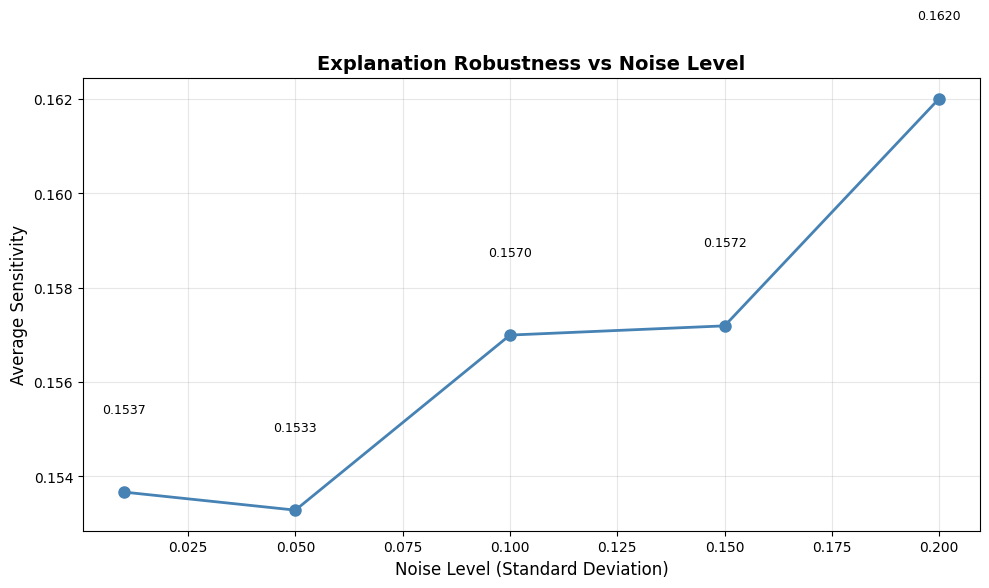


        Summary
        - Faithfulness: 0.9115718841552735
        - Robustness: 0.15662798583507537
        


In [42]:
local_xai_pipeline(img, target_class_resnet, gc_resnet, road_resnet)
local_xai_pipeline(img, target_class_alexnet, gc_alexnet, road_alexnet)

#### Integrated Gradients

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
C:\Users\pablo\AppData\Local\Temp\ipykernel_31152\2995559697.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  overlay.show()


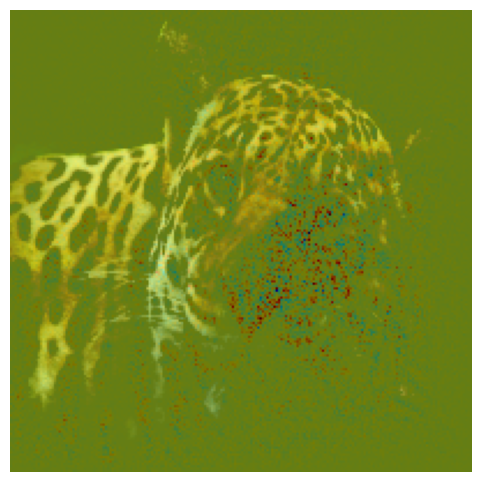

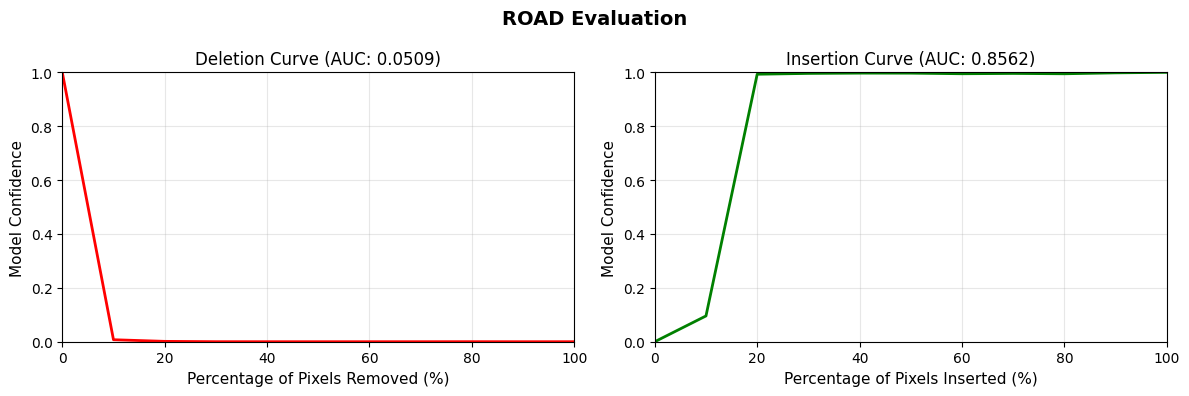

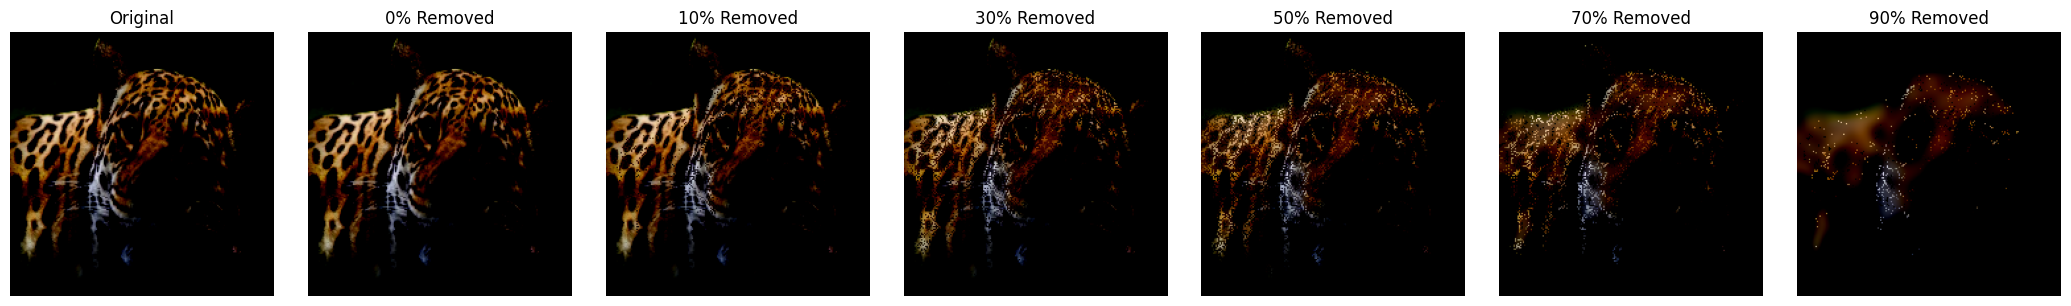

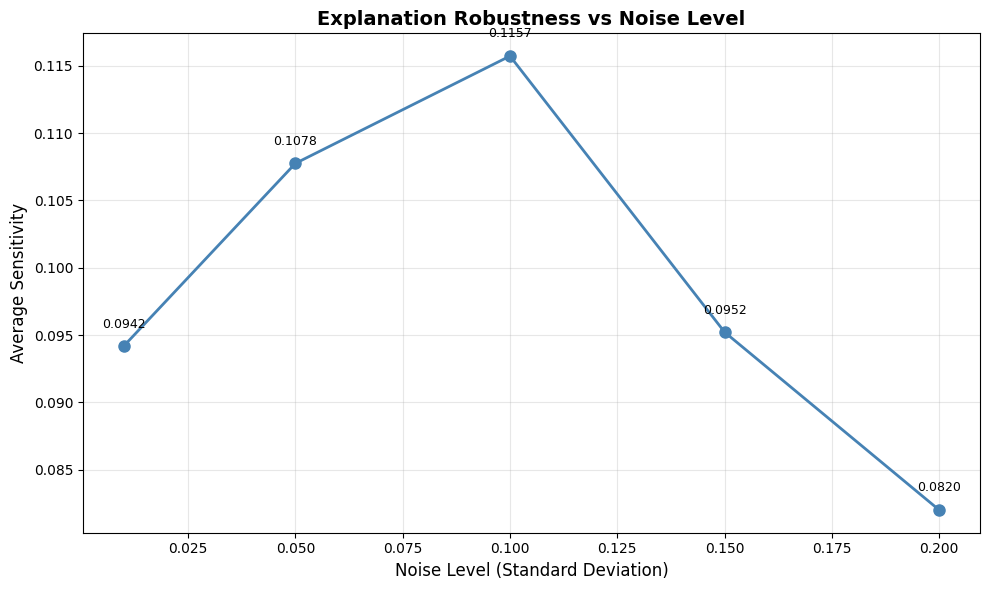


        Summary
        - Faithfulness: 0.05091580867767334
        - Robustness: 0.0989747866988182
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].


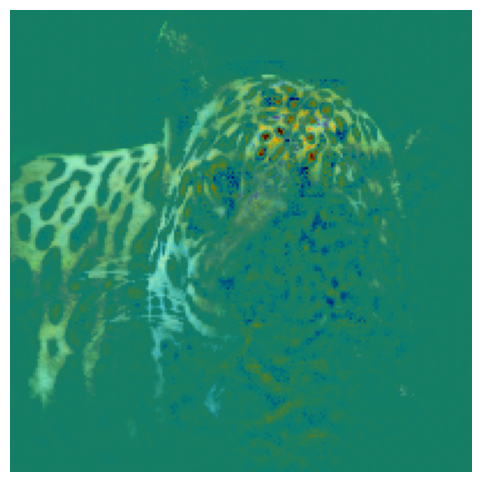

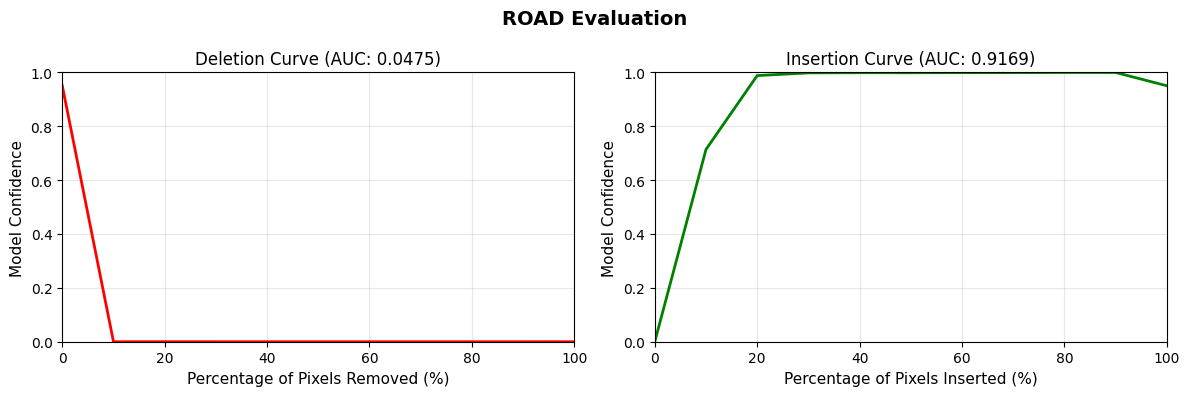

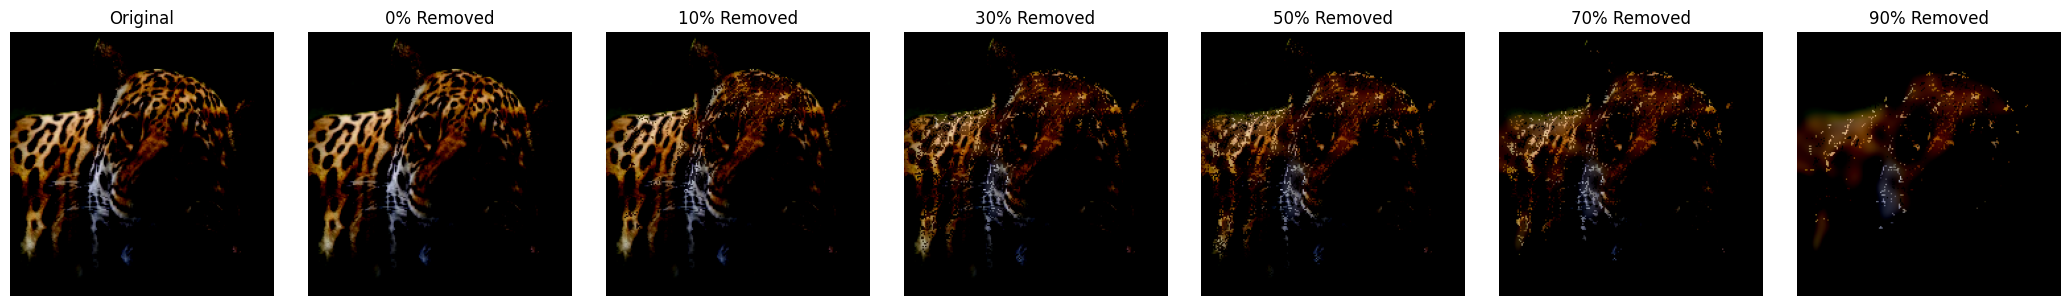

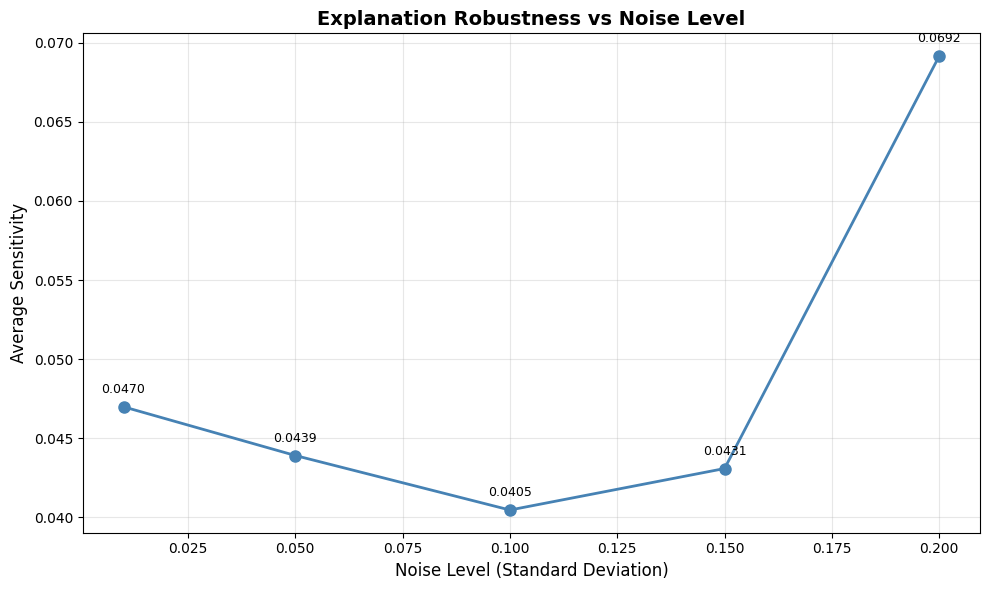


        Summary
        - Faithfulness: 0.04752233505249023
        - Robustness: 0.048726222664117816
        


In [43]:
local_xai_pipeline(img, target_class_resnet, ig_resnet, road_resnet)
local_xai_pipeline(img, target_class_alexnet, ig_alexnet, road_alexnet)

### Global XAI

In [44]:
data.dataset.classes

['AFRICAN LEOPARD',
 'CARACAL',
 'CHEETAH',
 'CLOUDED LEOPARD',
 'JAGUAR',
 'LIONS',
 'OCELOT',
 'PUMA',
 'SNOW LEOPARD',
 'TIGER']

Iteration 50/300, Class score: 27.7045
Iteration 100/300, Class score: 28.7782
Iteration 150/300, Class score: 29.7995
Iteration 200/300, Class score: 30.0484
Iteration 250/300, Class score: 30.1628
Iteration 300/300, Class score: 30.4040


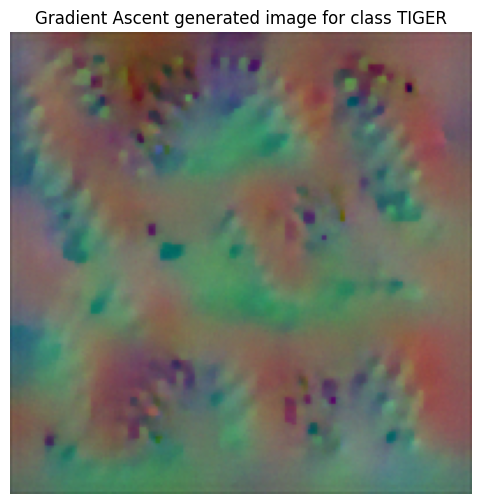

Iteration 50/300, Class score: 670.9706
Iteration 100/300, Class score: 730.1194
Iteration 150/300, Class score: 769.1707
Iteration 200/300, Class score: 815.5324
Iteration 250/300, Class score: 841.8107
Iteration 300/300, Class score: 847.9501


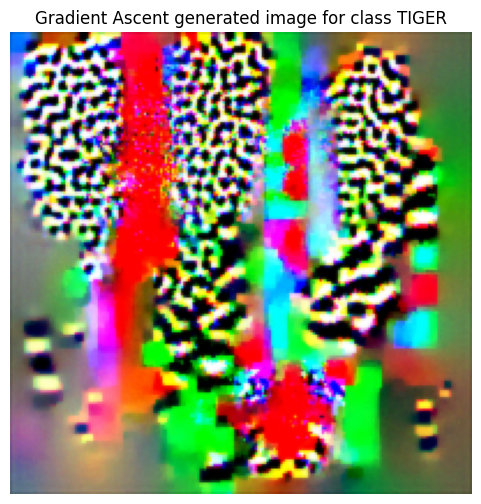

In [45]:
ga_class = 9
global_xai_pipeline(
    model_resnet,
    BIG_CATS_IMAGE_SIZE,
    3,
    ga_class,
    data.dataset.classes[ga_class],
    device
)
global_xai_pipeline(
    model_alexnet,
    BIG_CATS_IMAGE_SIZE,
    3,
    ga_class,
    data.dataset.classes[ga_class],
    device
)

## Pediatric Pneumonia

In [11]:
!python -m src.evaluate --data pediatric_pneumonia --model-name pretrained/pediatric_pneumonia_ResNet34_base_model

_, _, data = load_pediatric_pneumonia()

jit_model, model_name = load_model("pretrained/pediatric_pneumonia_ResNet34_base_model")
model = ResNet34(in_channels=1, num_classes=2, small_inputs=False)
model.load_state_dict(jit_model.state_dict())
pipeline = Classifier_Pipeline(model, config=Pipeline_Config(**PEDIATRIC_PNEUMONIA_PIPELINE_CONFIG))

Loading data for pediatric_pneumonia...DONE
Using model: pretrained/pediatric_pneumonia_ResNet34_base_model
Using device: cuda
Test accuracy: 0.634375
Evaluation registered with MLflow


c:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc = Grad_CAM(model, target_layer_name="processing_block.15.conv_branch.3")
ig = Integrated_Gradients(model)
road = ROAD(model, device=device)

### Local XAI

In [ ]:
imgs, labels = next(iter(data))

torch.Size([220, 220])


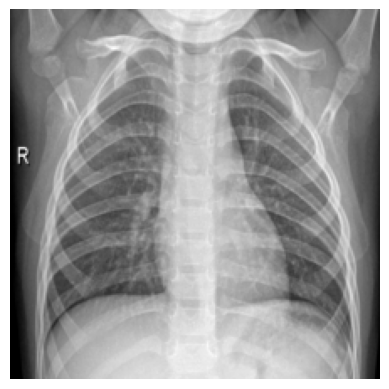

In [36]:
i = 125
img = imgs[i:i+1].to(device)
label = labels[i].item()

img_display = img.squeeze()
print(img_display.shape)
if hasattr(img_display, 'detach'):
    img_display = img_display.detach().cpu().numpy()

plt.imshow(img_display, cmap='gray')
plt.axis('off')
plt.show()

In [17]:
target_class = pipeline.predict(img).item()
classes = data.dataset.classes
print("Target class:", classes[label], "Predicted class:", classes[target_class])

Target class: NORMAL Predicted class: PNEUMONIA


#### Grad-CAM

C:\Users\pablo\AppData\Local\Temp\ipykernel_31152\2995559697.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  overlay.show()


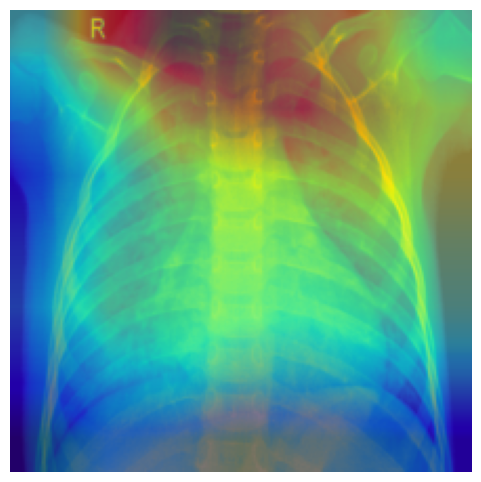

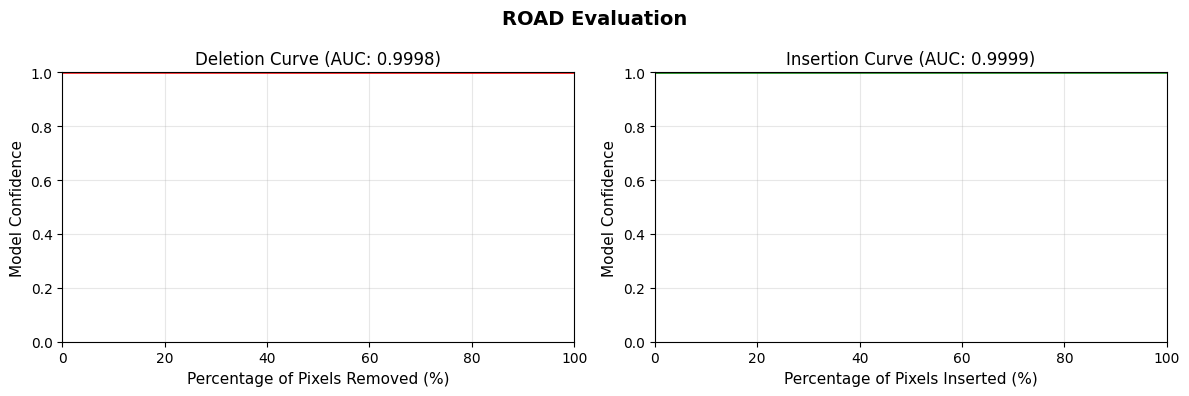

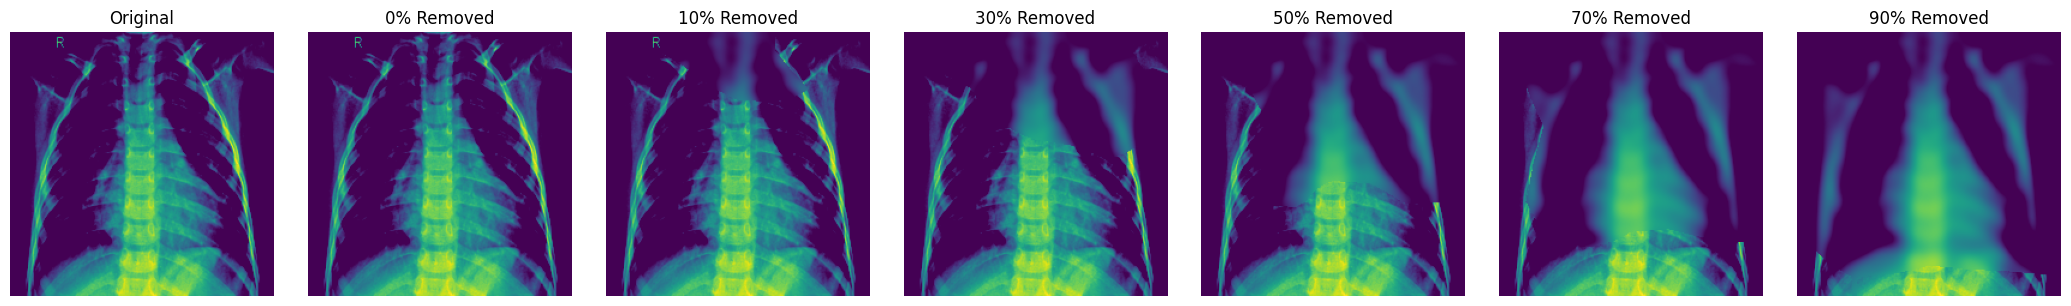

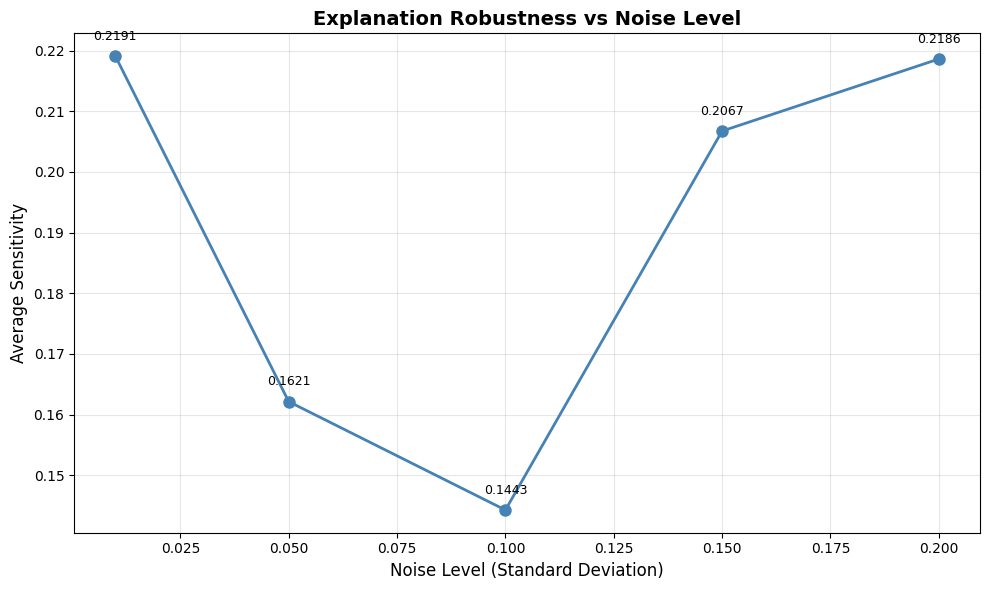


        Summary
        - Faithfulness: 0.9997994232177735
        - Robustness: 0.1901644915342331
        


In [50]:
local_xai_pipeline(img, target_class, gc, road)

#### Integrated Gradients

C:\Users\pablo\AppData\Local\Temp\ipykernel_31152\2995559697.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  overlay.show()


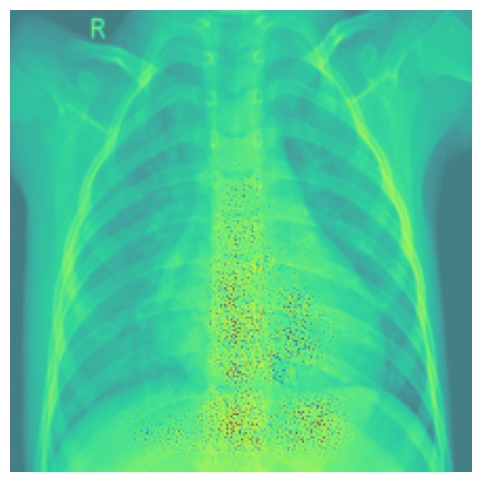

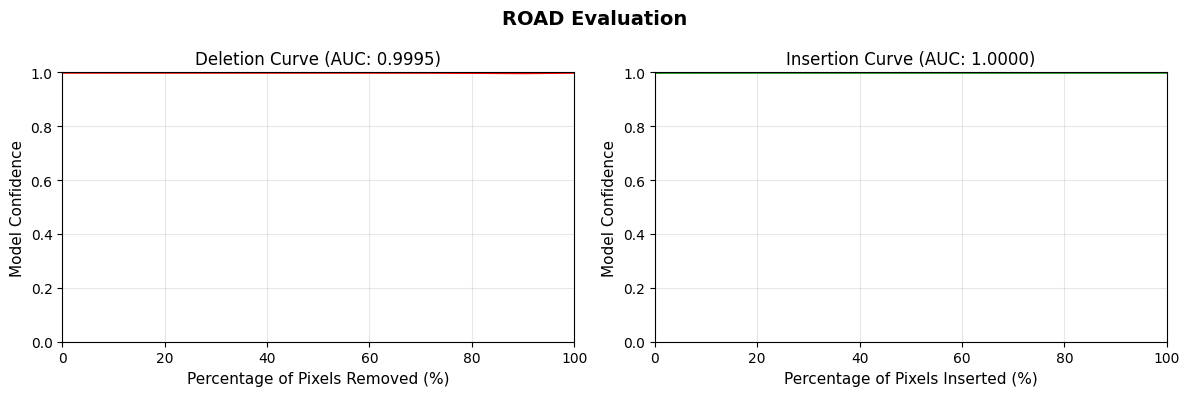

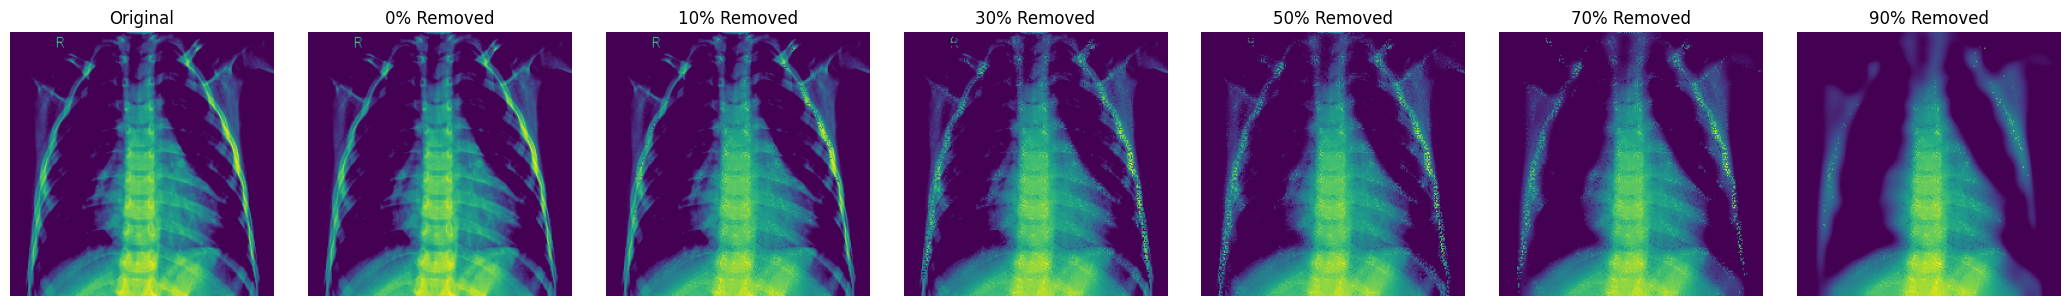

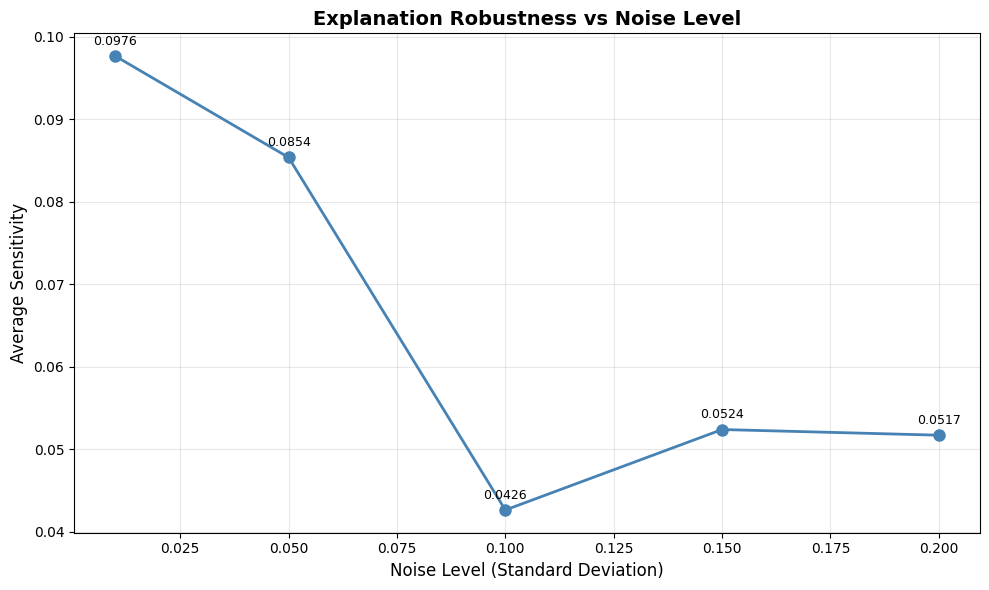


        Summary
        - Faithfulness: 0.9995228576660157
        - Robustness: 0.06594739779829979
        


In [51]:
local_xai_pipeline(img, target_class, ig, road)

### Global XAI

In [31]:
data.dataset.classes

['NORMAL', 'PNEUMONIA']

Iteration 50/300, Class score: 233.3668
Iteration 100/300, Class score: 242.8646
Iteration 150/300, Class score: 248.5452
Iteration 200/300, Class score: 251.9951
Iteration 250/300, Class score: 254.5401
Iteration 300/300, Class score: 255.3732


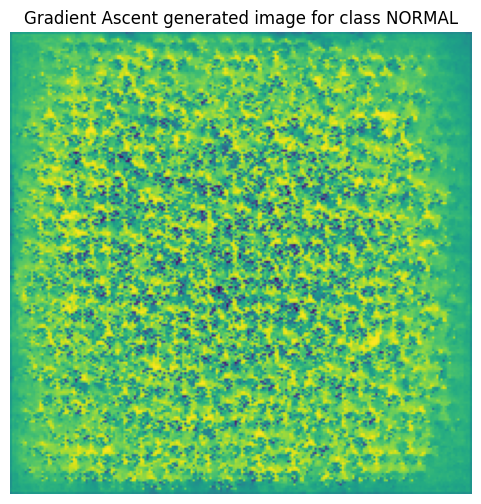

In [35]:
ga_class = 0
global_xai_pipeline(
    model,
    PEDIATRIC_PNEUMONIA_IMAGE_SIZE,
    1,
    ga_class,
    data.dataset.classes[ga_class],
    device
)